# TextCNN для классификации AG News

Ноутбук реализует классификатор TextCNN для датасета AG News с использованием PyTorch Lightning.

**Цель**: базовый CNN-классификатор текста; сравнить качество/скорость.

**Датасет**: AG News (train/val 90/10 сплит фиксированным сидом; test отдельно)

**Модель**: Embedding(200) → параллельные Conv1d ширин 3/4/5 (по 100 фильтров) → ReLU → max-over-time pooling → concat → Dropout(0.5) → Linear(4)


## Шаг 1: Импорты и настройка


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Seed set to 42


PyTorch version: 2.5.1+cu121
PyTorch Lightning version: 2.5.2
CUDA available: True


## Шаг 2: Загрузка и разбиение датасета

Загружаем AG News и создаём train/val сплит (90/10) с фиксированным сидом. Test набор отдельный.


In [2]:
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print(f"\nDataset structure:")
print(dataset)
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.1, 
    random_state=42, 
    stratify=train_labels
)

print(f"\nAfter split:")
print(f"Train: {len(train_texts)}")
print(f"Val: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(f"\nClasses: {class_names}")

print("\nSample examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"  Label: {train_labels[i]} ({class_names[train_labels[i]]})")
    print(f"  Text: {train_texts[i][:150]}...")


Loading AG News dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Train set size: 120000
Test set size: 7600

After split:
Train: 108000
Val: 12000
Test: 7600

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']

Sample examples:

Example 1:
  Label: 1 (Sports)
  Text: 10 seconds that change everything ATHENS - Ten seconds. Barely time enough to tie a shoe, wash a glass, get the paper off the porch. But when the mome...

Example 2:
  Label: 1 (Sports)
  Text: Charline Labonte rises to challenge Charline Labonte has served notice she wants to become the next starting goaltender of the Canadian women #39;s ho...

Example 3:
  Label: 2 (Business)
  Text: Ex-El Paso Traders Plead Guilty to False Reports Two more former natural gas traders for El Paso Corp. have pleaded guilty to reporting bogus deals in...


## Шаг 3: Токенизация и словарь

Простая токенизация: regex split и lowercasing. Строим словарь с min_freq=2, max_vocab≈30k, спец-токены `<pad>` и `<unk>`.


In [3]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
PAD_IDX = 0
UNK_IDX = 1

def simple_tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

print("Building vocabulary...")
word_counter = Counter()
for text in train_texts:
    tokens = simple_tokenize(text)
    word_counter.update(tokens)

print(f"Total unique words: {len(word_counter)}")
print(f"Words with freq >= 2: {sum(1 for count in word_counter.values() if count >= 2)}")

vocab = {PAD_TOKEN: PAD_IDX, UNK_TOKEN: UNK_IDX}
vocab_size = 2

max_vocab_size = 30000
for word, count in word_counter.most_common():
    if count >= 2 and vocab_size < max_vocab_size:
        vocab[word] = vocab_size
        vocab_size += 1

print(f"\nVocabulary size: {len(vocab)}")
print(f"Top 10 words: {list(vocab.keys())[:10]}")

idx_to_word = {idx: word for word, idx in vocab.items()}


Building vocabulary...
Total unique words: 62617
Words with freq >= 2: 42450

Vocabulary size: 30000
Top 10 words: ['<pad>', '<unk>', 'the', 'to', 'a', 'of', 'in', 'and', 's', 'on']


## Шаг 4: Dataset класс

Кастомный Dataset класс, который обрабатывает токенизацию, паддинг/обрезание до max_len=128.


In [4]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = simple_tokenize(text)
        indices = [self.vocab.get(token, UNK_IDX) for token in tokens]
        
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [PAD_IDX] * (self.max_len - len(indices))
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

max_len = 128
train_dataset = AGNewsDataset(train_texts, train_labels, vocab, max_len=max_len)
val_dataset = AGNewsDataset(val_texts, val_labels, vocab, max_len=max_len)
test_dataset = AGNewsDataset(test_texts, test_labels, vocab, max_len=max_len)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

sample_text, sample_label = train_dataset[0]
print(f"\nSample:")
print(f"  Text shape: {sample_text.shape}")
print(f"  Label: {sample_label.item()} ({class_names[sample_label.item()]})")
print(f"  First 20 tokens: {sample_text[:20].tolist()}")


Train dataset size: 108000
Val dataset size: 12000
Test dataset size: 7600

Sample:
  Text shape: torch.Size([128])
  Label: 1 (Sports)
  First 20 tokens: [136, 1788, 12, 674, 2622, 377, 1835, 1788, 3693, 84, 861, 3, 1686, 4, 7541, 5329, 4, 5770, 229, 2]


## Шаг 5: Модель TextCNN

Архитектура:
- Embedding слой: $E \in \mathbb{R}^{|V| \times d}$ где $d=200$, с `padding_idx=0`
- Параллельные свёрточные фильтры: $f \in \{3, 4, 5\}$ ширин фильтров, по 100 фильтров каждого
- Для каждой ширины $f$: $\text{Conv1d}(d, 100, f) \rightarrow \text{ReLU} \rightarrow \text{MaxPool}$
- Конкатенация признаков: $h = [h_3; h_4; h_5] \in \mathbb{R}^{300}$
- Dropout(0.5) → Linear(300, 4)


In [20]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, num_filters=100, filter_sizes=[3, 4, 5], num_classes=4, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2) # B x d x T
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(x))
            pooled = F.max_pool1d(conv_out, kernel_size=conv_out.size(2)).squeeze(2)
            conv_outputs.append(pooled)
        
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


## Шаг 6: Lightning модуль

PyTorch Lightning модуль с training/validation шагами, логированием train/val loss, val accuracy и val macro F1.


In [6]:
class TextCNNModule(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim=200, num_filters=100, filter_sizes=[3, 4, 5], num_classes=4, dropout=0.5, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = TextCNN(vocab_size, embed_dim, num_filters, filter_sizes, num_classes, dropout)
        self.lr = lr
        
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## Шаг 7: DataLoaders

Создаём DataLoaders с batch_size=128.


In [7]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 844
Val batches: 94
Test batches: 60


## Шаг 8: Обучение

Обучаем 3 эпохи с Adam оптимизатором (lr=1e-3), seed=42. Отслеживаем время эпохи.


In [8]:
vocab_size = len(vocab)
model = TextCNNModule(vocab_size=vocab_size, embed_dim=200, num_filters=100, filter_sizes=[3, 4, 5], num_classes=4, dropout=0.5, lr=1e-3)

trainer = pl.Trainer(
    max_epochs=3,
    accelerator='auto',
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=50
)

print("Starting training...")
start_time = time.time()
trainer.fit(model, train_loader, val_loader)
total_time = time.time() - start_time

print(f"\nTraining completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {total_time / 3:.2f} seconds")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Starting training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | TextCNN            | 6.2 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | val_f1    | MulticlassF1Score  | 0      | train
4 | criterion | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.966    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.



Training completed in 25.31 seconds
Average time per epoch: 8.44 seconds


## Шаг 9: Оценка на тесте

Оцениваем на test наборе: accuracy и macro F1 score.


In [9]:
test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        
        test_acc(logits, y)
        test_f1(logits, y)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(f"Test Accuracy: {test_acc.compute().item():.4f}")
print(f"Test Macro F1: {test_f1.compute().item():.4f}")


Test Accuracy: 0.9078
Test Macro F1: 0.9076


## Шаг 10: Измерение латентности

Измеряем латентность инференса на 1000 примерах.


In [10]:
model.eval()
test_subset = torch.utils.data.Subset(test_dataset, range(1000))
test_subset_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

warmup_batches = 10
with torch.no_grad():
    for i, batch in enumerate(test_subset_loader):
        if i < warmup_batches:
            _ = model(batch[0])
        else:
            break

times = []
with torch.no_grad():
    for batch in test_subset_loader:
        x, _ = batch
        start = time.time()
        _ = model(x)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        times.append(time.time() - start)

avg_latency = np.mean(times) * 1000
total_time = np.sum(times)
throughput = 1000 / total_time

print(f"Average latency per batch: {avg_latency:.2f} ms")
print(f"Total time for 1000 examples: {total_time:.4f} seconds")
print(f"Throughput: {throughput:.2f} examples/second")


Average latency per batch: 75.67 ms
Total time for 1000 examples: 0.6053 seconds
Throughput: 1652.00 examples/second


## Шаг 11: Confusion Matrix

Визуализируем confusion matrix на test наборе.


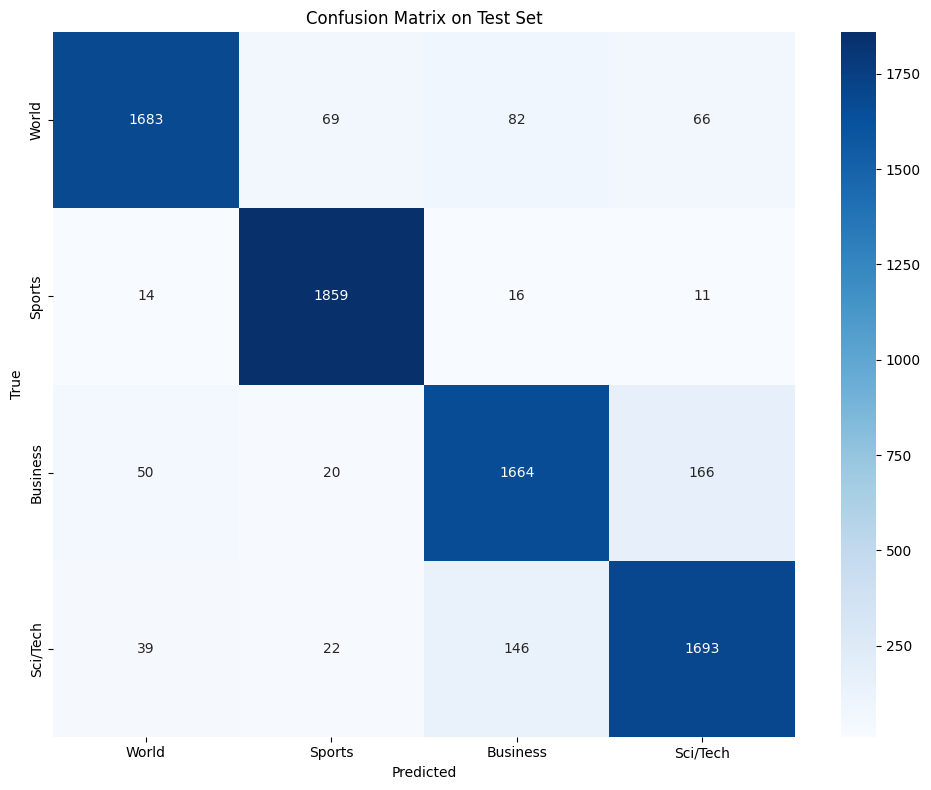

World: Precision=0.942, Recall=0.886, F1=0.913
Sports: Precision=0.944, Recall=0.978, F1=0.961
Business: Precision=0.872, Recall=0.876, F1=0.874
Sci/Tech: Precision=0.874, Recall=0.891, F1=0.883


In [11]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.show()

for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")


## Шаг 12: Анализ ошибок

Находим и показываем 5 типичных ошибок (текст, истинный лейбл, предсказанный лейбл).


In [12]:
errors = []
for i, (true_label, pred_label) in enumerate(zip(all_labels, all_preds)):
    if true_label != pred_label:
        errors.append((i, true_label, pred_label))

print(f"Total errors: {len(errors)} out of {len(all_labels)} ({len(errors)/len(all_labels)*100:.2f}%)")
print("\n5 Typical Errors:\n")

for idx, (i, true_label, pred_label) in enumerate(errors[:5]):
    text = test_texts[i]
    print(f"Error {idx+1}:")
    print(f"  True: {class_names[true_label]} ({true_label})")
    print(f"  Pred: {class_names[pred_label]} ({pred_label})")
    print(f"  Text: {text[:200]}...")
    print()


Total errors: 701 out of 7600 (9.22%)

5 Typical Errors:

Error 1:
  True: Sci/Tech (3)
  Pred: Business (2)
  Text: Card fraud unit nets 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m....

Error 2:
  True: Sci/Tech (3)
  Pred: Business (2)
  Text: Teenage T. rex's monster growth Tyrannosaurus rex achieved its massive size due to an enormous growth spurt during its adolescent years....

Error 3:
  True: Sci/Tech (3)
  Pred: Business (2)
  Text: IBM to hire even more new workers By the end of the year, the computing giant plans to have its biggest headcount since 1991....

Error 4:
  True: Sci/Tech (3)
  Pred: Business (2)
  Text: Rivals Try to Turn Tables on Charles Schwab By MICHAEL LIEDTKE     SAN FRANCISCO (AP) -- With its low prices and iconoclastic attitude, discount stock broker Charles Schwab Corp. (SCH) represented an ...

Error 5:
  True: World (0)
  Pred: Business (2)
  Te